In [1]:
%run ../src/game.py
%run ../src/ipd.py
%run ../src/strategies.py
%run ../src/tools.py
dip =[(3,3),(0,5),(5,0),(1,1)]   # Dilemme du prisonnier



## Tests d'équivalence de stratégies

Les ensembles de stratégies que nous traitons sont parfois redondants : il contiennent les mêmes stratégies écrites de différentes manières. Il semble donc interessant de pouvoir simplifier des ensembles de stratégies en suprimant les doublons qu'ils peuvent contenir. 
Malheureusement, chacun le sait depuis Turing, l'équivalence de deux programmes est indécidable. Il n'y a donc pas de test parfait. Il est néanmoins possible de fournir des outils permettant d'avancer dans ce problème de simplification.


Pour savoir si deux stratégies sont différentes, il suffit de les faire jouer contre une stratégie de référence et s'assurer qu'elles jouent différemment face à cet adversaire. Evidemment selon la complexité de cette stratégie de référence, le test est plus ou moins efficace. Si les stratégies jouent la même chose, cela ne fournit néanmoins pas une preuve de leur équivalence. L'équivalence est semi-décidable : si les stratégies jouent différemment il est sûr qu'elles sont différentes, mais si elles jouent de manière identique, c'est peut-etre que la stratégie de référence n'a pas sû révéler leur différence de comportement.
La fonction `testEquivUnit` réalise ce test. On lui passe un couple de stratégies à tester et une stratégie de référence `opponent`, et elle compare ces deux stratégies durant `length` tours d'un meeting. Elle renvoie un booléen : équivalent (avec doute) ou pas.

In [2]:
def testEquivUnit(strategies, opponent, length):
    sA,sB = strategies
    rounds1 = []
    rounds2  = []
    m1 = Meeting(g, sA, opponent, length)
    m1.run()
    m2 = Meeting(g, sB, opponent, length)
    m2.run()
    if m1.s1_score == m2.s1_score :
        if m1.s1_rounds == m2.s1_rounds :
            return True
    return False


#def testEquivUnit(strategies, opponent, length):
#    scores = []
#    rounds = []
#    for strat in strategies :
#        m = Meeting(g, strat, opponent, length)
#        m.run()
#        scores += [m.s1_score] 
#        rounds += [' '.join(map(str, m.s1_rounds)) ] 
#    # if the two strategies have the same score
#    if len(set(scores)) == 1:
#        # check if they played the same rounds
#        if len(set(rounds)) == 1:
#            return True
#    return False


print(testEquivUnit((Tft(), Spiteful())  , Periodic("CCDCD"), 100))
print(testEquivUnit((Tft(), Mem(0,1,"cCD")),  Periodic("CCDCD"), 100))



False
True


## Exercice 1

Deux stratégies peuvent bien évidemment obtenir le même score face à un adversaire commun,tout en ayant joué des coups différents. Pouvez vous identifier un tel cas ? On pourra utiliser le package `itertools` et sa méthode `permutations` qui permet facilement de prendre 3 stratégies parmi n

In [3]:
def test2(strategies, opponent, length):
    sA,sB = strategies
    rounds1 = []
    rounds2  = []
    m1 = Meeting(g, sA, opponent, length)
    m1.run()
    m2 = Meeting(g, sB, opponent, length)
    m2.run()
    if m1.s1_score == m2.s1_score :
        if m1.s1_rounds != m2.s1_rounds :  # THE TEST HAS CHANGED COMPARED TO testEquivUnit
            return True
    return False


bag = getMem(1,0)
bags = itertools.permutations(bag, 3)
for b in bags : 
    if test2((b[0], b[1]), b[2], 10):
        print(b[0].name + " and "+b[1].name+" produce the same score but don't play the same rounds against : "+b[2].name)            
        break

        
        
#sA = Mem(1,1,"CCCCC")
#sB = Mem(1,1,"CCDDC")
#opponent = Mem(1,1,"DCDCC")
#m = Meeting(g,sA,opponent,10)
#m.run()
#print(m.s1.name + "\t" + ' '.join(map(str, m.s1_rounds)) + " " + str(m.s1_score))
#print(m.s2.name + "\t" + ' '.join(map(str, m.s2_rounds)) + " " + str(m.s2_score))
#print()
#m = Meeting(g,sB,opponent,10)
#m.run()
#print(m.s1.name + "\t" + ' '.join(map(str, m.s1_rounds)) + " " + str(m.s1_score))
#print(m.s2.name + "\t" + ' '.join(map(str, m.s2_rounds)) + " " + str(m.s2_score))

CDC and DDC produce the same score but don't play the same rounds against : CCC


Le choix de la stratégie de référence est capital. Si elle est trop "faible", elle ne permet pas aux deux stratégies comparées de se "révéler" et indique alors qu'elles sont équivalentes alors qu'elles ne le sont pas, comme ci-dessous : `Tft` et `Spiteful` sont clairement différentes, et pourtant, face  `All_C` elles ont le même comportement.


In [3]:
testEquivUnit((Tft(), Spiteful()), Periodic('C'), 100)

True

Un test plus robuste pourrait être de les faire jouer contre `Periodic('CCD')`. Cette dernière permet à Tft et Spiteful de révéler leeur véritable comportement. On a cette fois ci la preuve que ces deux stratégies ne sont pas équivalentes.

In [4]:
testEquivUnit((Tft(), Spiteful()), Periodic('CD'), 100)

False

Afin d'améliorer cette comparaison de deux stratégies, il est préférable de les comparer non pas à une seule stratégie de référence, mais à un ensemble de stratégies de référence. On compare nos deux stratégies contre chaque élément de cet ensemble, ce qui constitue un test surement plus robuste. Bien évidemment dès que l'une de celles-ci indique une différence entre deux 2 stratégies, le test peut s'arrêter.
La fonction `testEquivMultiple` fonctionne comme précédemment, mais cette fois en cherchant à trouver une différence de comportement grâce à une liste d'opposants. Comme précédemmnt elle renvoie un booléen : équivalent (avec doute) ou pas.

In [5]:
def testEquivMultiple(strategies, opponents, length):
    for opponent in opponents : 
        equiv = testEquivUnit(strategies, opponent, length)
        if equiv == False :
            return False
    return True

testEquivMultiple((Tft(), Spiteful()),[Periodic('CDCCDDC'), Periodic('DDCDCDD')], 10)

False

Pour simplifier un ensemble de stratégies, il suffit maintenant d'effectuer le test précédent sur tous les couples possibles. Les stratégies identifiées comme potentiellement équivalentes sont alors regroupées.
la fonction `classesEquiv(l, opponents, length)` effectue ce test sur l'ensemble `l`. Elle renvoie dans un dictionnaire les classes d'équivalence identifiées.
Par exemple si on a strat1 équivalente à strat2 ainsi que strat3 qui elle n'a pas d'équivalente, la fonction va renvoyer un dictionnaire : `{strat1 : [strat2] , strat3 : []}`

L'ensemble des clés de ce disctionnaire constitue l'ensemble de stratégies simplifié, et chaque entrée du dictionnaire correspond à un ensemble de stratégies équivalentes.

In [6]:
def classesEquiv(l, opponents, length):
    m = dict()
    while len(l) > 0 :
        m[l[0]] = []
        ind = [0]
        for j in range(len(l[1:])):
            if testEquivMultiple([l[0], l[j + 1]], opponents, length):
                m[l[0]] += [l[j + 1]]
                ind += [j + 1]
        ltmp = []
        for i in range(len(l)):
            if i not in ind :
                ltmp += [l[i]]
        l = ltmp
    return m


# This function allows you to display the names of the strategies instead of the instance number.
def printDict(ce):
    for key in ce.keys() :
        if len(ce[key]) > 0:
            print("\n" + key.name + " : " , end =" " )
        else :
            print("\n"+ key.name + ": []"  , end =" ")
        for value in ce[key]:
            print(value.name , end =" ")
    print(" ")
    
    
L = [Tft(), Spiteful(), Mem(0,1,"cCD"),  Mem(1,1,"cCDDD"), Periodic("CDC") ]
ce = classesEquiv(L, [Periodic('CDCCDDC'), Periodic('DDCDCDD')], 10)
# printDict(ce)
print("Simplified set size : " + str(len(ce.keys())))

Simplified set size : 3


On rappelle que la qualité de cette simplification dépend très fortement de la qualité de la liste de référence. On le constate aisément en tentant de simplifier `mem(1,2)` face à une liste de plus en plus grande de stratégies de référence.


In [7]:
# Mem(1,2) contains 1024 strategies

# Without any opponent, they are all considered equivalent.
ce = classesEquiv(getMem(1,2), [], 10)
print(len(ce.keys()))

# Comparing with simply ALL_C , only 9 different strategies are available
ce = classesEquiv(getMem(1,2), [Periodic('C')], 10)
print(len(ce.keys()))

# We're gradually strengthening the test
ce = classesEquiv(getMem(1,2), [Periodic('C'), Periodic('CDCCDDC'), Periodic('DDCDCDD')], 10)
print(len(ce.keys()))

ce = classesEquiv(getMem(1,2), [Periodic('C'), Periodic('CDCCDDC'), Periodic('DDCDCDD'),Gradual()], 10)
print(len(ce.keys()))

# So? How large is this simplified set really?


1
12
712
728


On peut encore renforcer le test en commençant par faire jouer toutes les stratégies de l'ensemble à tester entre elles. Bien évidemment si des stratégies sont identiques, elles doivent avoir le même score dans ce tournoi. On peut donc se contenter de tester les équivalences sur les ensembles de stratégies qui obtiennent en Tournoi un score identique. Rajouter cette équivalence des scores renforce encore un peu plus notre test.
Bien évidemment ceci se fait au détriment du temps de calcul.
La fonction `simplify` effectue ce travail. Elle fonctionne comme précédemment mais démarre par un tournoi afin d'identifier les paquets de stratégies ayant le même score. On concatène ensuite chacun des dictionnaires

In [8]:
def simplify(l, opponents, length):
    scores = dict()
    t = Tournament(g, opponents + l, length)
    t.run()
    res = t.matrix['Total']
    for strat in l : 
        score = res[strat.name]
        if score not in scores :
            scores[score] = [strat]
        else : 
            scores[score] += [strat]
    
    d = dict()
    for item in scores.values():
        # if more than one strategy has the same score, test classesEquiv
        if len(item) > 1 :
            res = classesEquiv(item, opponents, length)
            for it in res.keys():
                d[it] = res[it]
        else : 
            d[item[0]] = []
    return d

        
    
        
strats = simplify(getMem(1,2) , [Periodic('C'), Periodic('CDCCDDC'), Periodic('DDCDCDD'),Gradual()], 10)
print("Simplified set size : " + str(len(strats)))

# # RECORD BROKEN! 820... but this test remains undecidable, it is nevertheless subject to a doubt... 
        
# printDict(strats)  

Simplified set size : 820


## Une approche incrémentale

Pour savoir si une stratégie peut être notée avec des étoiles, il faut savoir si elle utilise tous les éléments de son code. Si ce n'est pas le cas on repère ces éléments et on les remplace par des étoiles. Une étoile indique que ce gène peut être remplacé par n'importe quelle valeur puisqu'il ne sert pas.
La fonction `construirePattern` prend pour agrument un génotype de stratégie de type Memory et qui renvoie ce génotype éventuellement réécrit avec des *
L'idée générale de l'algorithme utilisé consiste à construire peu à peu la liste de tous les passés possibles, et donc, de mettre des étoiles pour les passés qui n'apparaissent pas dans cette liste.

In [59]:
def construirePattern(X,Y,genotype):
    me = genotype[max(X,Y) - X : max(X,Y)].upper()
    #print(me)
    opponent=""
    L = [x for x in itertools.product(['C', 'D'],repeat=Y)]
    L = [list(elem) for elem in L]
    print(L)
    
    L1 = [x for x in itertools.product(['C', 'D'],repeat=X+Y)]
    L1 = [list(elem) for elem in L1]
    
    possiblePast = []
    for elem in L :
        possiblePast += [[me]+elem] 
    #print(possiblePast)
    lenpossiblePast = len(possiblePast)
    for i in range(lenpossiblePast):
        past = possiblePast[i][1]
        a = genotype[L1.index(possiblePast[i])+max(X,Y)].upper()
        past1 = [a, past, 'C']
        past2 = [a, past, 'D']
        if past1 not in possiblePast :
            possiblePast += [past1]
        if past2 not in possiblePast :
            possiblePast += [past2]
   
    print(possiblePast)
    
    
    ind=[]
    for i in range(len(L1)):
        if L1[i] not in possiblePast:
            ind += [i]
    
    genotypeStar = genotype[0 : max(X,Y)]
    for i in range(len(L1)):
        if i not in ind : 
            genotypeStar += genotype[max(X,Y) + i]
        else :
            genotypeStar += "*"
    
    return genotypeStar


print(construirePattern(1,2,"ccCCDDCCDD"))
# ccCCDDCCDD

print(construirePattern(1,2,"ccCCCCCCCC"))
# ccCCCC****


[['C', 'C'], ['C', 'D'], ['D', 'C'], ['D', 'D']]
C
-------
['C', 'C', 'C']
['C', 'C', 'D']
----------
C
-------
['C', 'C', 'C']
['C', 'C', 'D']
----------
D
-------
['D', 'D', 'C']
['D', 'D', 'D']
----------
D
-------
['D', 'D', 'C']
['D', 'D', 'D']
----------
[['C', 'C', 'C'], ['C', 'C', 'D'], ['C', 'D', 'C'], ['C', 'D', 'D'], ['D', 'D', 'C'], ['D', 'D', 'D']]
ccCCDD**DD
[['C', 'C'], ['C', 'D'], ['D', 'C'], ['D', 'D']]
C
-------
['C', 'C', 'C']
['C', 'C', 'D']
----------
C
-------
['C', 'C', 'C']
['C', 'C', 'D']
----------
C
-------
['C', 'D', 'C']
['C', 'D', 'D']
----------
C
-------
['C', 'D', 'C']
['C', 'D', 'D']
----------
[['C', 'C', 'C'], ['C', 'C', 'D'], ['C', 'D', 'C'], ['C', 'D', 'D']]
ccCCCC****


### Tableau de synthèse

Etant donnée une base de comparaison, réaliser un tableau contenant pour chacune des classes de Memory classiques, la synthèse des tailles obtenues après simplication via ClassesEquiv et via Simplify 

In [ ]:
base  = [Periodic('CDCCDDC'), Periodic('DDCDCDD'),Gradual()]

Mem01 = getMem(0,1)
Mem10 = getMem(1,0)
Mem11 = getMem(1,1)
Mem12 = getMem(1,2)
Mem21 = getMem(2,1)

ce01 = classesEquiv(Mem01, base, 10)
ce10 = classesEquiv(Mem10, base, 10)
ce11 = classesEquiv(Mem11, base, 10)
ce12 = classesEquiv(Mem12, base, 10)
ce21 = classesEquiv(Mem21, base, 10)

simp01 = simplify(Mem01, base, 10)
simp10 = simplify(Mem10, base, 10)
simp11 = simplify(Mem11, base, 10)
simp12 = simplify(Mem12, base, 10)
simp21 = simplify(Mem21, base, 10)

# idem avec simplify

tab = pd.DataFrame(
        np.nan, ["Mem 0 1","Mem 1 0","Mem 1 1", "Mem 1 2", "Mem 2 1"], ["All strategies", "After classesEquiv","After simplify"]
    )
tab.at["Mem 0 1", "All strategies" ] = len(Mem01)
tab.at["Mem 1 0", "All strategies" ] = len(Mem10)
tab.at["Mem 1 1", "All strategies" ] = len(Mem11)
tab.at["Mem 1 2", "All strategies" ] = len(Mem12)
tab.at["Mem 2 1", "All strategies" ] = len(Mem21)
tab.at["Mem 0 1", "After classesEquiv" ] = len(ce01.keys())
tab.at["Mem 1 0", "After classesEquiv" ] = len(ce10.keys())
tab.at["Mem 1 1", "After classesEquiv" ] = len(ce11.keys())
tab.at["Mem 1 2", "After classesEquiv" ] = len(ce12.keys())
tab.at["Mem 2 1", "After classesEquiv" ] = len(ce21.keys())
tab.at["Mem 0 1", "After simplify" ] = len(simp01.keys())
tab.at["Mem 1 0", "After simplify" ] = len(simp10.keys())
tab.at["Mem 1 1", "After simplify" ] = len(simp11.keys())
tab.at["Mem 1 2", "After simplify" ] = len(simp12.keys())
tab.at["Mem 2 1", "After simplify" ] = len(simp21.keys())
tab

# Améliorer l'affichage des stratégies

Les classes d'équivalence permettent de mettre en évidence des ensembles de stratégies qui jouent de manière identique. Par construction, ces stratégies identiques ont une partie de leur génotype en commun.
Il est alors interessant d'afficher les ensembles de stratégies équivalentes par une seule et même représentation en remplaçant les coups qui ne sont pas impactant par des *

In [11]:
def computeStar(strategies):
    l = math.log2(len(strategies))
    assert l == int(l)
    ind_stars = []
    len_genome = len(strategies[0].genome)
    for i in range(len_genome):
        letter = strategies[0].genome[i]
        for j in range(1, len(strategies)):
            if letter != strategies[j].genome[i]:
                ind_stars += [i]
                break
    assert len(ind_stars) == l
    new_genome = ""
    for i in range(len_genome):
        if i not in ind_stars:
            new_genome += strategies[0].genome[i]
        else :
            new_genome += "*"
    #print(new_genome)
    return new_genome
            
print(computeStar([Mem(1,1,"CDCD"),Mem(1,1,"CDCC")]))
print(computeStar([Mem(1,2,"CDCDCDDDCC"),Mem(1,2,"CDCDDDDDCC"),Mem(1,2,"CDDDCDDDCC"),Mem(1,2,"CDDDDDDDCC")]))
      

CDC*
CD*D*DDDCC


Petite vérification

26


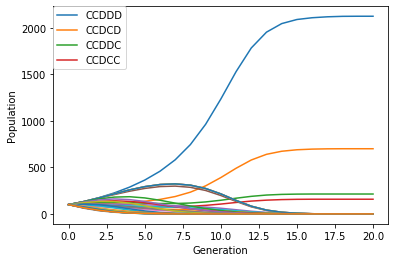

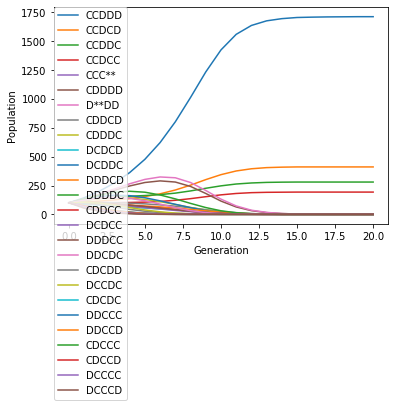

In [20]:
mem11 = getMem(1,1)
simpl = simplify(mem11, [Periodic('CDCCDDC'), Periodic('DDCDCDD')], 10)
print(len(simpl))

bag = []
for key in simpl.keys():
    if len(simpl[key]) > 0:
        name = computeStar([key]+simpl[key])
        bag += [key.clone(name)]
    else :
        bag += [key]

e1 = Ecological(g, mem11)
e1.run()

evol=e1.historic
nbSurvivors = len(evol.iloc[-1][evol.iloc[-1]>0])
e1.drawPlot(None,nbSurvivors)


e2 = Ecological(g, bag)
e2.run()

evol=e2.historic
nbSurvivors = len(evol.iloc[-1][evol.iloc[-1]>0])
e2.drawPlot(None,None)


# On constate qu'avec mem(1,1) on passe de 32 stratégies à 26 stratégies
# On constate aussi que la compétition des simplifiées donne le même classement excepté 
# le fait que ALL_C survit dans la version simplifiée

In [59]:
def trie_Mem1(strategies):
    strategies.sort(key=lambda x: x.genome)
    return strategies

def trie_Mem2(strategies):
    strategies.sort(key=lambda x: x.genome, reverse=True)
    return strategies

def trie_Mem3(strategies):
    strategies.sort(key=lambda x: ''.join(reversed(x.genome)))
    return strategies

def trie_Mem4(strategies):
    strategies.sort(key=lambda x: ''.join(reversed(x.genome)), reverse=True)
    return strategies


sortMem11 = trie_Mem4(getMem(1,1))


In [51]:
def rec_simplify(l, opponents, length, batchSize):
    size = len(l)
    strats = []
    simplified = dict()
    for i in range(int(size/batchSize)):
        #print(i * batchSize)
        #print((i+1) * batchSize)
        strats += l[i * batchSize : (i+1) * batchSize]
        res = simplify(strats, opponents, length)
        print("{} strategies deleted".format(len(strats) - len(res)))
        for strat in res.keys() :
            if strat not in simplified : 
                simplified[strat] = res[strat]
            else : 
                simplified[strat] += res[strat]
        strats = list(simplified.keys())
    return simplified


        
# print(rec_simplify([Tft(), Spiteful(), Mem(0,1,"cCD"),  Mem(1,1,"cCDDD"), Periodic("CDC"), Periodic('C') ], [Periodic('CCD'), Periodic('DDC')] , 10, 2))
# print(" ")
# sortMem12 = trie_Mem(getMem(1,2))
# rec_simplify(sortMem12, [Periodic('CCD'), Periodic('DDC')] , 10, 32)

Petite vérification

In [52]:
res_rec = rec_simplify(getMem(1,2), [Periodic('CCD'), Periodic('DDC')] , 10, 32)
res = simplify(getMem(1,2), [Periodic('CCD'), Periodic('DDC')], 10)
res_rec == res

0
32
27 strategies deleted
32
64
15 strategies deleted
64
96
14 strategies deleted
96
128
18 strategies deleted
128
160
6 strategies deleted
160
192
1 strategies deleted
192
224
7 strategies deleted
224
256
13 strategies deleted
256
288
3 strategies deleted
288
320
5 strategies deleted
320
352
4 strategies deleted
352
384
15 strategies deleted
384
416
4 strategies deleted
416
448
6 strategies deleted
448
480
11 strategies deleted
480
512
16 strategies deleted
512
544
22 strategies deleted
544
576
13 strategies deleted
576
608
6 strategies deleted
608
640
0 strategies deleted
640
672
6 strategies deleted
672
704
0 strategies deleted
704
736
6 strategies deleted
736
768
0 strategies deleted
768
800
2 strategies deleted
800
832
5 strategies deleted
832
864
3 strategies deleted
864
896
14 strategies deleted
896
928
2 strategies deleted
928
960
6 strategies deleted
960
992
8 strategies deleted
992
1024
14 strategies deleted


False

In [53]:
print(len(res))
print(len(res_rec))

817
758


In [47]:
res_rec = rec_simplify(getMem(1,1), [Periodic('CCD'), Periodic('DDC')] , 10, 8)
res = simplify(getMem(1,1), [Periodic('CCD'), Periodic('DDC')], 10)
print(res_rec == res)
print(len(res))
print(len(res_rec))
printDict(res)
printDict(res_rec)


3 strategies deleted
0 strategies deleted
1 strategies deleted
2 strategies deleted
False
26
26

CCCCC :  CCCCD CCCDC CCCDD 
CCDCC: [] 
CCDCD: [] 
CCDDC: [] 
DCCDC: [] 
CCDDD: [] 
CDCCC: [] 
CDCCD: [] 
CDCDC: [] 
CDCDD: [] 
CDDCC: [] 
DDDCC: [] 
CDDCD: [] 
CDDDC: [] 
CDDDD: [] 
DCCCC: [] 
DCCCD: [] 
DCCDD :  DCDDD DDCDD DDDDD 
DCDCC: [] 
DCDCD: [] 
DCDDC: [] 
DDCCC: [] 
DDCCD: [] 
DDCDC: [] 
DDDCD: [] 
DDDDC: []  

CCCCC :  CCCCD CCCDC CCCDD 
CCDCC: [] 
CCDCD: [] 
CCDDC: [] 
CCDDD: [] 
CDCCC: [] 
CDCCD: [] 
CDCDC: [] 
CDCDD: [] 
CDDCC: [] 
CDDCD: [] 
CDDDC: [] 
CDDDD: [] 
DCCCC: [] 
DCCCD: [] 
DCCDC: [] 
DCCDD :  DCDDD DDCDD DDDDD 
DCDCC: [] 
DCDCD: [] 
DCDDC: [] 
DDDCC: [] 
DDCCC: [] 
DDCCD: [] 
DDCDC: [] 
DDDCD: [] 
DDDDC: []  


L'aggressivité des stratégies

In [5]:
m = Meeting(g, Periodic('D'), Periodic('D'), 100)
m.run()
print(m.s1_score)

100


In [6]:
def getAgressivityClasses(bag):
    aggressivity = {'IC':[], 'SC':[],'IA':[],'SA':[]}
    for strat in bag : 
        m1 = Meeting(g, strat, Periodic('C'), 100)
        m1.run()
        m2 = Meeting(g, strat, Periodic('D'), 100)
        m2.run()
        if m1.s1_score == 300:
             aggressivity['IC'] += [strat.name]
        if m1.s1_score > 300:
             aggressivity['SA'] += [strat.name]
        if m2.s1_score == 100:
             aggressivity['IA'] += [strat.name]
        if m2.s1_score < 100:
             aggressivity['SC'] += [strat.name]
    return aggressivity
        
    
print(getAgressivityClasses(getClassicals()))
        
        

{'IC': ['per_C', 'tft', 'spiteful', 'softmajo', 'pavlov', 'tf2t', 'hardtft', 'slowtft', 'gradual'], 'SC': ['per_C', 'tft', 'spiteful', 'softmajo', 'per_DDC', 'per_CCD', 'per_CD', 'pavlov', 'tf2t', 'hardtft', 'slowtft', 'gradual', 'prober'], 'IA': ['per_D', 'hardmajo', 'mistrust'], 'SA': ['per_D', 'hardmajo', 'per_DDC', 'per_CCD', 'mistrust', 'per_CD', 'prober']}


L'aggressivité des stratégies avant et après simplification

In [13]:
def createTab(bag):
    agr = getAgressivityClasses(bag)
    simplified = simplify(bag, [Periodic('CCD'), Periodic('DDC')], 10)
    agrS = getAgressivityClasses(simplified)
    tab = pd.DataFrame(
            np.nan, ["IC","SC","IA", "SA"], ["Before simplify","After simplify"]
        )
    for key in agr :
        tab.at[key,"Before simplify" ] = len(agr[key])
    for key in agrS :
        tab.at[key, "After simplify"] = len(agrS[key])
    return tab

createTab(getMem(1,1))


,Before simplify,After simplify
IC,8.0,5.0
SC,24.0,21.0
IA,8.0,5.0
SA,24.0,21.0


Maintenant, regardons avec Mem(1,2)

In [14]:
createTab(getMem(1,2))

,Before simplify,After simplify
IC,128.0,89.0
SC,896.0,729.0
IA,128.0,88.0
SA,896.0,728.0
